# Modeling: Random Forest & XGB

Using random forest models to predict cvd risk for demographic features, then using ensemble methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
#importing dataset with demographic data 
df = pd.read_csv('~/Downloads/capstone/CapstoneJulyNYC/Data/Clean_Data/final_data.csv')
df.set_index('SEQN',inplace=True)
df

,sex,age,fam_income_poverty_ratio,Education_College graduate or above,Education_Don't Know,Education_High school graduate/GED or equivalent,Education_Less than 9th grade,Education_Refused,Education_Some college or AA degree,Marital_Status_Married,...,heart_attack_No,heart_attack_Yes,stroke_Don't Know,stroke_No,stroke_Yes,close_relative_heart_attack_Don't Know,close_relative_heart_attack_No,close_relative_heart_attack_Yes,weight_kg,height_cm
SEQN,,,,,,,,,,,,,,,,,,,,,
73557,1,69,0.84,0,0,1,0,0,0,0,...,1,0,0,0,1,0,1,0,78.3,171.3
73558,1,54,1.78,0,0,1,0,0,0,1,...,1,0,0,1,0,0,1,0,89.5,176.8
73559,1,72,4.51,0,0,0,0,0,1,1,...,1,0,0,1,0,0,0,1,88.9,175.3
73561,0,73,5.00,1,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,52.0,162.4
73562,1,56,4.79,0,0,0,0,0,1,0,...,0,1,0,1,0,0,1,0,105.0,158.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83723,1,61,3.53,0,0,0,0,0,0,1,...,1,0,0,1,0,0,1,0,99.5,173.5
83724,1,80,3.09,0,0,1,0,0,0,1,...,1,0,0,1,0,0,1,0,77.1,176.0
83726,1,40,3.81,0,0,0,1,0,0,0,...,1,0,0,1,0,0,1,0,79.0,171.7


### Preprocessing and Filtering Data

In [6]:
# bining age 
# Create age bins
bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ['20-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+']
df['age_bins'] = pd.cut(df['age'], bins=bins, labels=labels, right = False, include_lowest=True)

# One-hot encode age_bins
df = pd.get_dummies(df, columns=['age_bins'], drop_first=False)

In [8]:
columns_to_change =  ['age_bins_20-30','age_bins_31-40','age_bins_41-50','age_bins_51-60','age_bins_61-70','age_bins_71-80','age_bins_81+']
df[columns_to_change] = df[columns_to_change].astype(int)

In [10]:
df

,sex,age,fam_income_poverty_ratio,Education_College graduate or above,Education_Don't Know,Education_High school graduate/GED or equivalent,Education_Less than 9th grade,Education_Refused,Education_Some college or AA degree,Marital_Status_Married,...,close_relative_heart_attack_Yes,weight_kg,height_cm,age_bins_20-30,age_bins_31-40,age_bins_41-50,age_bins_51-60,age_bins_61-70,age_bins_71-80,age_bins_81+
SEQN,,,,,,,,,,,,,,,,,,,,,
73557,1,69,0.84,0,0,1,0,0,0,0,...,0,78.3,171.3,0,0,0,0,1,0,0
73558,1,54,1.78,0,0,1,0,0,0,1,...,0,89.5,176.8,0,0,0,1,0,0,0
73559,1,72,4.51,0,0,0,0,0,1,1,...,1,88.9,175.3,0,0,0,0,0,1,0
73561,0,73,5.00,1,0,0,0,0,0,1,...,1,52.0,162.4,0,0,0,0,0,1,0
73562,1,56,4.79,0,0,0,0,0,1,0,...,0,105.0,158.7,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83723,1,61,3.53,0,0,0,0,0,0,1,...,0,99.5,173.5,0,0,0,0,1,0,0
83724,1,80,3.09,0,0,1,0,0,0,1,...,0,77.1,176.0,0,0,0,0,0,0,1
83726,1,40,3.81,0,0,0,1,0,0,0,...,0,79.0,171.7,0,0,1,0,0,0,0


### Setting up X and Y

In [15]:
# Filter out at risk variables

# Step 1: Define the cardiovascular disease conditions
cvd_conditions = [
    'congestive_heart_failure_Yes', 
    'coronary_heart_disease_Yes', 
    'heart_attack_Yes', 
    'stroke_Yes'
]

df['have_cvd'] = df[cvd_conditions].max(axis=1)

# Step 2: Data Preparation
# Define the variables of interest
demographic_features = [
    'sex',      
  # 'age', 
    'age_bins_20-30',
    'age_bins_31-40','age_bins_41-50','age_bins_51-60',
    'age_bins_61-70','age_bins_71-80','age_bins_81+',
    'height_cm', 
    'weight_kg', 
    'Smoked_100_cigs_Yes',
#    'Marital_Status_Married','Marital_Status_Never married', 
#    'Marital_Status_Separated','Marital_Status_Widowed',
    'Education_College graduate or above', 
    'Education_High school graduate/GED or equivalent',
    'Education_Less than 9th grade',
    'Education_Some college or AA degree'    
]

#converting age to int 
df['age'] = df['age'].astype(int)

# Create additional features based on CVD indicators
df['has_angina'] = df['angina_Yes'].astype(int)
df['has_family_history'] = df['close_relative_heart_attack_Yes'].astype(int)

#creating interaction features
df['age_family_history'] = df['age'] * df['has_family_history']
#df['age_smoked'] = df['age'] * df['Smoked_100_cigs_Yes']
df['sex_family_history'] = df['sex'] * df['has_family_history']


In [17]:
# 'have_cvd' is target variable (1 for CVD, 0 for no CVD)
X = df[demographic_features + ['has_angina', 'has_family_history','sex_family_history','age_family_history']] #'age_smoked']]
y = df['have_cvd']  # Make sure both 0 and 1 are present

In [19]:
from sklearn.model_selection import train_test_split

#Stratified Train-Test Split 
X['age_bins_have_cvd'] = (df[['age_bins_20-30', 'age_bins_31-40', 'age_bins_41-50', 
                              'age_bins_51-60', 'age_bins_61-70', 'age_bins_71-80', 
                              'age_bins_81+']].idxmax(axis=1) + '_' + y.astype(str))

# Now stratify on this combined feature (optional)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=X['age_bins_have_cvd'], random_state=42
)

# Drop the temporary stratification column from the final X_train and X_test
X_train = X_train.drop(columns=['age_bins_have_cvd'])
X_test = X_test.drop(columns=['age_bins_have_cvd'])

In [21]:
X.shape

(5546, 20)

In [23]:
y.shape

(5546,)

In [25]:
print("y_train distribution:\n", y_train.value_counts())

y_train distribution:
 have_cvd
0    4003
1     433
Name: count, dtype: int64


### EDA of Age Distribution and CVD Disease After Stratification

<Figure size 1000x600 with 0 Axes>

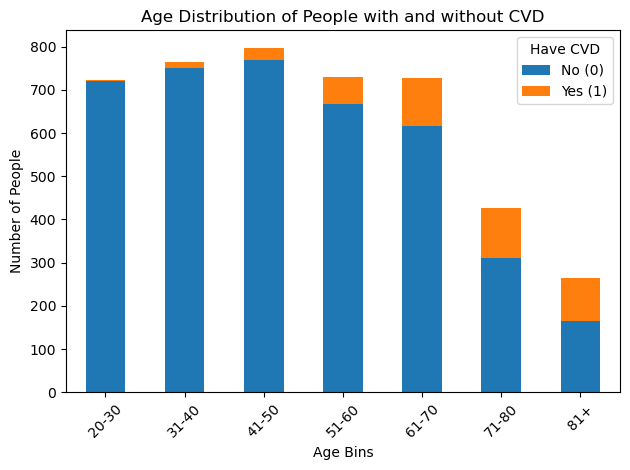

In [28]:
# Step 1: Create a single 'age_bin' categorical column based on binary age bins
def assign_age_bin(row):
    if row['age_bins_20-30'] == 1:
        return '20-30'
    elif row['age_bins_31-40'] == 1:
        return '31-40'
    elif row['age_bins_41-50'] == 1:
        return '41-50'
    elif row['age_bins_51-60'] == 1:
        return '51-60'
    elif row['age_bins_61-70'] == 1:
        return '61-70'
    elif row['age_bins_71-80'] == 1:
        return '71-80'
    elif row['age_bins_81+'] == 1:
        return '81+'
    return 'Unknown'

# Apply the function to create 'age_bin' column
X_train['age_bin'] = X_train.apply(assign_age_bin, axis=1)

# Step 2: Combine the new 'age_bin' column with the target column 'have_cvd'
data = pd.concat([X_train[['age_bin']], y_train], axis=1)

# Step 3: Group by the new 'age_bin' and 'have_cvd' class, then count occurrences
age_cvd_counts = data.groupby(['age_bin', 'have_cvd']).size().unstack()

# Step 4: Plot the counts for each age bin with CVD and without CVD
plt.figure(figsize=(10, 6))
age_cvd_counts.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'])

# Set titles and labels
plt.title('Age Distribution of People with and without CVD')
plt.xlabel('Age Bins')
plt.ylabel('Number of People')
plt.legend(title='Have CVD', labels=['No (0)', 'Yes (1)'])
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


In [39]:
X_train = X_train.drop(columns='age_bin')

## Random Forest Model

### Over and Under Sampling for Class Imbalance (Using SMOTEENN)

In [41]:
from imblearn.combine import SMOTEENN

In [43]:
X_train.columns

Index(['sex', 'age_bins_20-30', 'age_bins_31-40', 'age_bins_41-50',
       'age_bins_51-60', 'age_bins_61-70', 'age_bins_71-80', 'age_bins_81+',
       'height_cm', 'weight_kg', 'Smoked_100_cigs_Yes',
       'Education_College graduate or above',
       'Education_High school graduate/GED or equivalent',
       'Education_Less than 9th grade', 'Education_Some college or AA degree',
       'has_angina', 'has_family_history', 'sex_family_history',
       'age_family_history'],
      dtype='object')

In [45]:
smote_enn = SMOTEENN(random_state=42)
X_train_resampled_smote_enn, y_train_resampled_smote_enn = smote_enn.fit_resample(X_train, y_train)

#### Initializing and Training Random Forest Classifier

In [48]:
rf_smote_enn = RandomForestClassifier(random_state=42, n_estimators=100)  # choosing n_estimators
rf_smote_enn.fit(X_train_resampled_smote_enn, y_train_resampled_smote_enn)

RandomForestClassifier(random_state=42)

In [50]:
# Step 3: Predict on test set using the Random Forest model
y_prob_rf_smote_enn = rf_smote_enn.predict_proba(X_test)[:, 1]  # Get the predicted probabilities
y_pred_custom_threshold_rf_smote_enn = (y_prob_rf_smote_enn >= 0.5).astype(int)

In [52]:
# Step 4: Evaluate the Random Forest model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold_rf_smote_enn))
print("\nClassification Report with Threshold (0.5):\n", classification_report(y_test, y_pred_custom_threshold_rf_smote_enn))
print("\nAccuracy Score:\n", accuracy_score(y_test, y_pred_custom_threshold_rf_smote_enn))

Confusion Matrix:
 [[836 166]
 [ 48  60]]

Classification Report with Threshold (0.5):
               precision    recall  f1-score   support

           0       0.95      0.83      0.89      1002
           1       0.27      0.56      0.36       108

    accuracy                           0.81      1110
   macro avg       0.61      0.69      0.62      1110
weighted avg       0.88      0.81      0.84      1110


Accuracy Score:
 0.8072072072072072


#### Plotting Precision-Recall curve

In [55]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_rf_smote_enn)

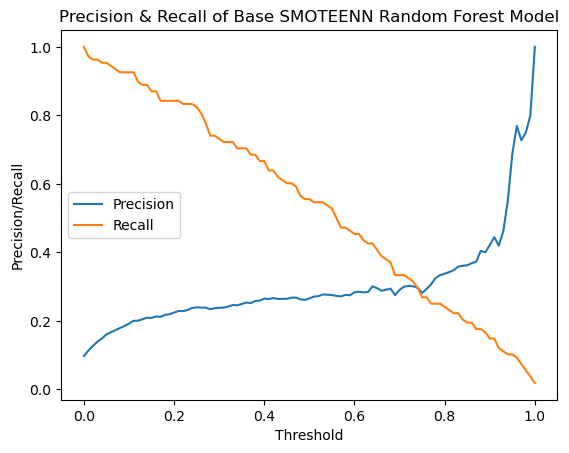

In [57]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision & Recall of Base SMOTEENN Random Forest Model')
plt.show()

#### Hyperparameter Tuning SMOTEENN RF Model

In [60]:
# Create SMOTEENN object
smote_enn = SMOTEENN(random_state=42)

# Create Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid for Random Forest
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', None]
}

# Create a pipeline with SMOTEENN and Random Forest
pipeline_rf = Pipeline([
    ('smote_enn', smote_enn),   # Apply SMOTEENN for resampling
    ('rf', rf)                  # Random Forest model
])

# Setup GridSearchCV with the pipeline
grid_search_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model on the original training data
grid_search_rf.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search_rf.best_params_)

# Evaluate on the test data
best_rf_model = grid_search_rf.best_estimator_
test_accuracy_rf = best_rf_model.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy_rf:.4f}')

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Test Accuracy: 0.8216


In [62]:
#fitting with best hyperparameters 
rf_smoteenn_tuned = RandomForestClassifier(random_state=42, 
                                         n_estimators=200, bootstrap=False, max_depth= 20, 
                                         max_features = 'sqrt', min_samples_leaf = 1,
                                         min_samples_split = 10
                                        )  
rf_smoteenn_tuned.fit(X_train_resampled_smote_enn, y_train_resampled_smote_enn)

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [84]:
#Predict on training set using the Random Forest model
y_prob_train_rf_smoteenn_tuned = rf_smoteenn_tuned.predict_proba(X_train)[:, 1]  # Get the predicted probabilities for training data
y_train_pred_custom_threshold_rf_smoteenn_tuned = (y_prob_train_rf_smoteenn_tuned >= .5).astype(int)


In [90]:
# Step 3: Predict on test set using the Random Forest model
y_prob_rf_smoteenn_tuned = rf_smoteenn_tuned.predict_proba(X_test)[:, 1]  # Get the predicted probabilities
y_pred_custom_threshold_rf_smoteenn_tuned = (y_prob_rf_smoteenn_tuned >= .5).astype(int)

In [92]:
# Step 4: Evaluate the Random Forest model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold_rf_smoteenn_tuned))
print("\nClassification Report with Threshold (0.5):\n", classification_report(y_test,y_pred_custom_threshold_rf_smoteenn_tuned))
print("\nAccuracy Score:\n", accuracy_score(y_test,y_pred_custom_threshold_rf_smoteenn_tuned))

Confusion Matrix:
 [[856 146]
 [ 48  60]]

Classification Report with Threshold (0.5):
               precision    recall  f1-score   support

           0       0.95      0.85      0.90      1002
           1       0.29      0.56      0.38       108

    accuracy                           0.83      1110
   macro avg       0.62      0.70      0.64      1110
weighted avg       0.88      0.83      0.85      1110


Accuracy Score:
 0.8252252252252252


In [94]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_rf_smoteenn_tuned)

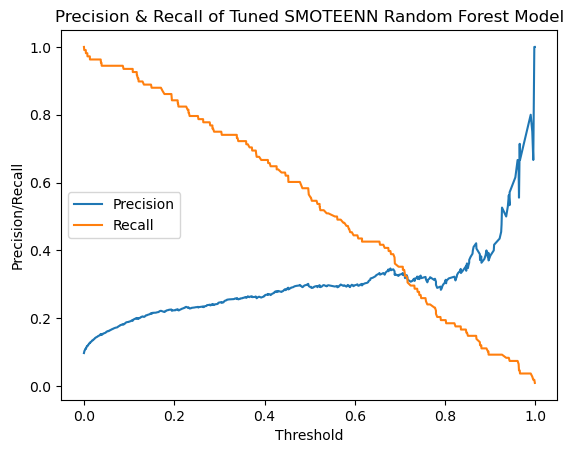

In [96]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision & Recall of Tuned SMOTEENN Random Forest Model')
plt.show()

In [98]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred_custom_threshold_rf_smoteenn_tuned)
test_accuracy = accuracy_score(y_test, y_pred_custom_threshold_rf_smoteenn_tuned)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9085
Test Accuracy: 0.8252


### Feature Importances

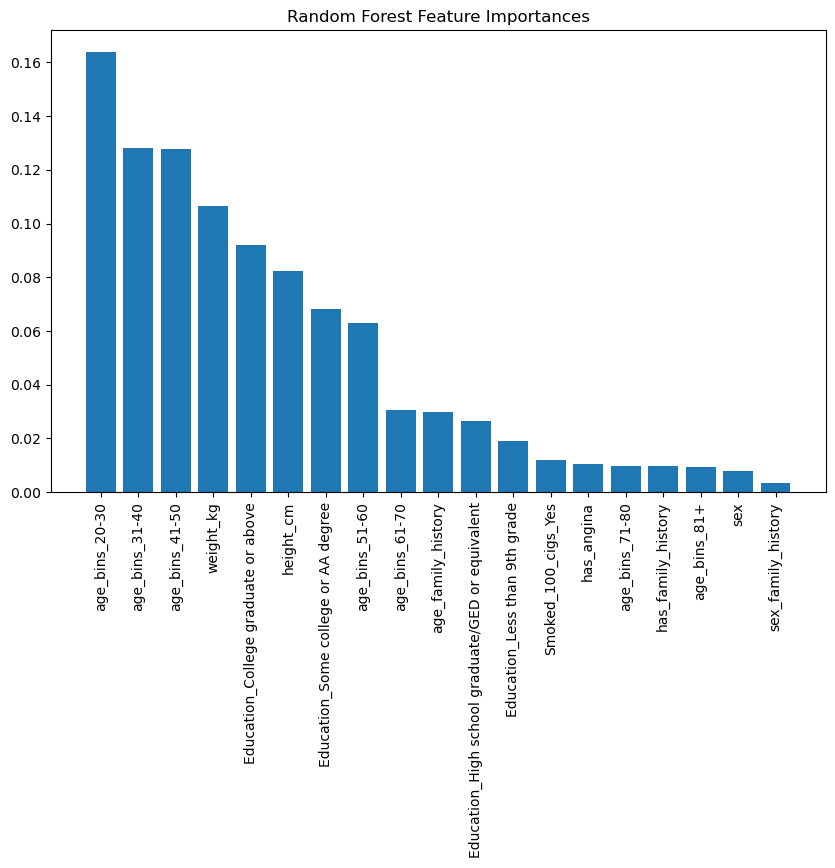

In [101]:
importances_rf = rf_smoteenn_tuned.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

# Plot feature importances
plt.figure(figsize=(10,6))
plt.title("Random Forest Feature Importances")
plt.bar(range(len(importances_rf)), importances_rf[indices_rf], align='center')
plt.xticks(range(len(importances_rf)), X_train.columns[indices_rf], rotation=90)
plt.show()

#### SHAP for RF Model

In [104]:
import shap 
shap.initjs()

In [105]:
X.columns

Index(['sex', 'age_bins_20-30', 'age_bins_31-40', 'age_bins_41-50',
       'age_bins_51-60', 'age_bins_61-70', 'age_bins_71-80', 'age_bins_81+',
       'height_cm', 'weight_kg', 'Smoked_100_cigs_Yes',
       'Education_College graduate or above',
       'Education_High school graduate/GED or equivalent',
       'Education_Less than 9th grade', 'Education_Some college or AA degree',
       'has_angina', 'has_family_history', 'sex_family_history',
       'age_family_history', 'age_bins_have_cvd'],
      dtype='object')

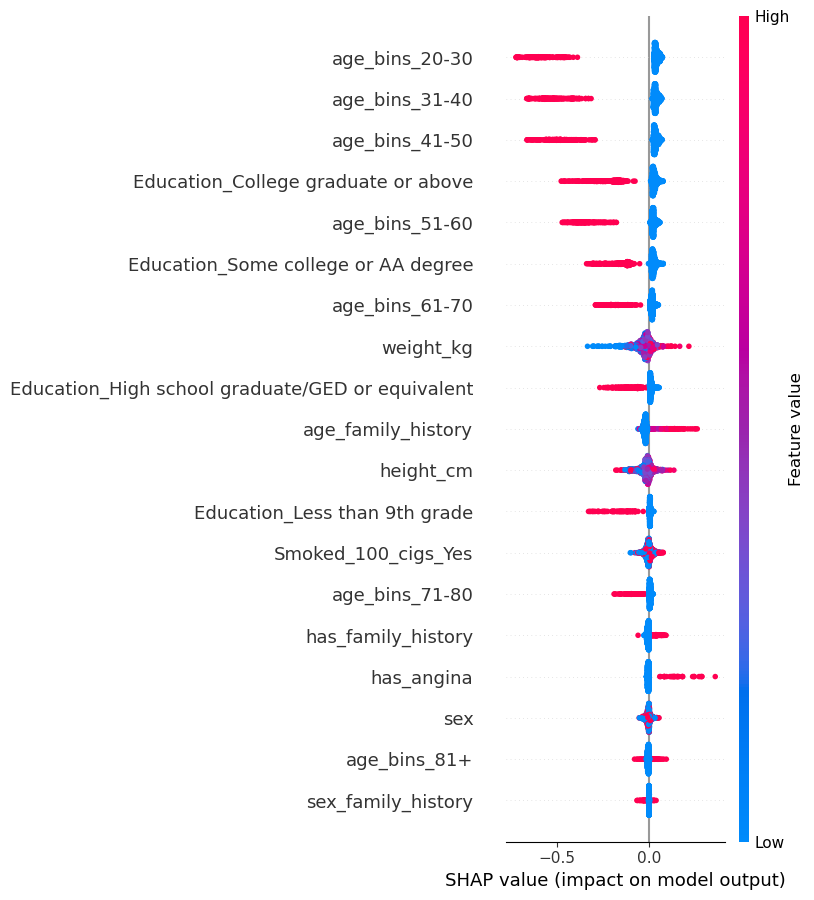

In [110]:
# shap summary plot

explainer = shap.TreeExplainer(rf_smoteenn_tuned)
shap_values = explainer(X_test)

#calculate SHAP values for test set
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[:,:,1], X_test)

## XGB Model with SMOTEENN & Class Weighting

In [124]:
# Create an XGBoost model instance
import xgboost as xgb

xgb_model_smote_enn = xgb.XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handle class imbalance
    random_state=42,
    use_label_encoder=False,  # Disable warning for label encoding
    eval_metric='logloss'  # Set evaluation metric
)

# Fit the model on the resampled dataset
xgb_model_smote_enn.fit(X_train_resampled_smote_enn, y_train_resampled_smote_enn)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [126]:
# Predict on the test set 
y_prob_xgb_smote_enn = xgb_model_smote_enn.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
y_pred_custom_threshold_xgb_smote_enn = (y_prob_xgb_smote_enn >= 0.5).astype(int)  # Default threshold is 0.5, adjust if needed

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold_xgb_smote_enn))
print("\nClassification Report with Threshold (0.5):\n", classification_report(y_test, y_pred_custom_threshold_xgb_smote_enn))
print("\nAccuracy Score:\n", accuracy_score(y_test, y_pred_custom_threshold_xgb_smote_enn))

Confusion Matrix:
 [[752 250]
 [ 36  72]]

Classification Report with Threshold (0.5):
               precision    recall  f1-score   support

           0       0.95      0.75      0.84      1002
           1       0.22      0.67      0.33       108

    accuracy                           0.74      1110
   macro avg       0.59      0.71      0.59      1110
weighted avg       0.88      0.74      0.79      1110


Accuracy Score:
 0.7423423423423423


In [128]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb_smote_enn)

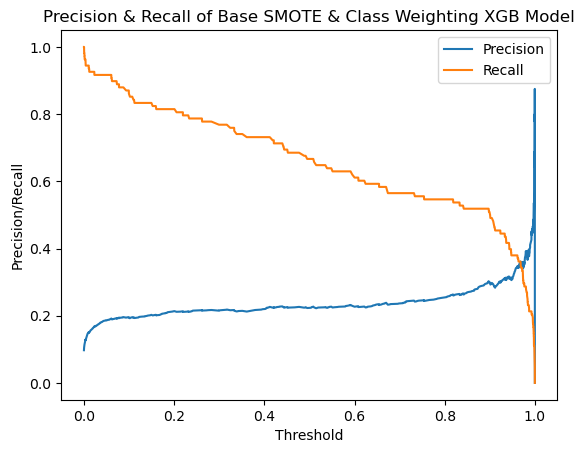

In [130]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision & Recall of Base SMOTE & Class Weighting XGB Model')
plt.show()

### Tuning XGBoost Hyperparameters with SMOTEENN

In [132]:
# Create SMOTEENN object
smote_enn = SMOTEENN(random_state=42)

# Create XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define hyperparameter grid for XGBoost
param_grid_xgb = {
    'xgb__max_depth': [3, 5, 7],  # Note the xgb__ prefix
    'xgb__learning_rate': [0.1, 0.01, 0.001],
    'xgb__subsample': [0.5, 0.7, 1],
    'xgb__gamma': [0, 1, 10]
}

# Create a pipeline with SMOTE and XGBoost
pipeline_xgb = Pipeline([
    ('smote_enn', smote_enn),   # Apply SMOTEEN for resampling
    ('xgb', xgb_model)  # XGBoost model
])


# Setup GridSearchCV with the pipeline
grid_search_xgb = GridSearchCV(estimator=pipeline_xgb, param_grid=param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model on the original training data
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search_xgb.best_params_)

# Evaluate on the test data
best_xgb_model = grid_search_xgb.best_estimator_
test_accuracy_xgb = best_xgb_model.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy_xgb:.4f}')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters:  {'xgb__gamma': 1, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__subsample': 0.7}
Test Accuracy: 0.8126


In [134]:
# using best hyperparameters, setting max_delta_step to 1 for imbalanced dataset, and using SMOTE
xgb_model_smoteenn_tuned = XGBClassifier(
 
    random_state=42,
     #scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    use_label_encoder=False,  # Disable warning for label encoding
    eval_metric='logloss',  # Set evaluation metric
    gamma=1,learning_rate=0.1, max_depth=7,subsample=0.7,max_delta_step=1) #best hyperparameters
xgb_model_smoteenn_tuned.fit(X_train_resampled_smote_enn, y_train_resampled_smote_enn)


 # Handle class imbalance # scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [136]:
y_train_pred = xgb_model_smoteenn_tuned.predict(X_train)
y_test_pred = xgb_model_smoteenn_tuned.predict(X_test)

In [138]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.8589
Test Accuracy: 0.8108


In [140]:
# Predict on the test set 
y_prob_xgb_smoteenn_tuned = xgb_model_smoteenn_tuned.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
y_pred_custom_threshold_xgb_smoteenn_tuned = (y_prob_xgb_smoteenn_tuned >= 0.5).astype(int)  # Default threshold is 0.5, adjust if needed

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold_xgb_smoteenn_tuned))
print("\nClassification Report with Default Threshold (0.5):\n", classification_report(y_test, y_pred_custom_threshold_xgb_smoteenn_tuned))
print("\nAccuracy Score:\n", accuracy_score(y_test, y_pred_custom_threshold_xgb_smoteenn_tuned))

Confusion Matrix:
 [[833 169]
 [ 41  67]]

Classification Report with Default Threshold (0.5):
               precision    recall  f1-score   support

           0       0.95      0.83      0.89      1002
           1       0.28      0.62      0.39       108

    accuracy                           0.81      1110
   macro avg       0.62      0.73      0.64      1110
weighted avg       0.89      0.81      0.84      1110


Accuracy Score:
 0.8108108108108109


### Tuning Threshold

In [143]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb_smoteenn_tuned)

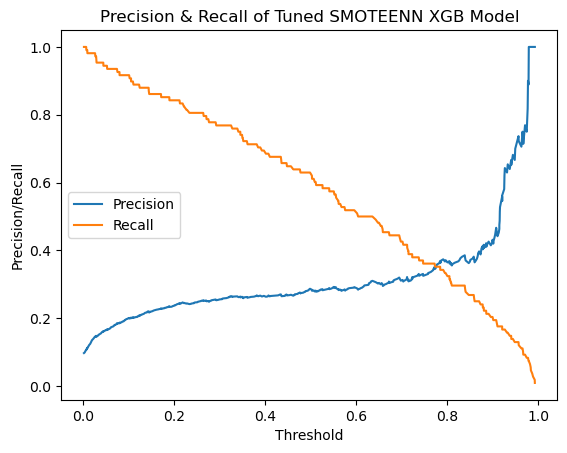

In [145]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision & Recall of Tuned SMOTEENN XGB Model')
plt.show()

In [149]:
# Predict probabilities
y_prob_xgb_smoteenn_tuned = xgb_model_smoteenn_tuned.predict_proba(X_test)[:, 1]

# Adjust the threshold
y_pred_custom_threshold_xgb_smoteenn_tuned = (y_prob_xgb_smoteenn_tuned >= 0.45).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold_xgb_smoteenn_tuned))

# Evaluate with new threshold
print("\nClassification Report (Threshold 0.45):\n", classification_report(y_test, y_pred_custom_threshold_xgb_smoteenn_tuned))

Confusion Matrix:
 [[811 191]
 [ 38  70]]

Classification Report (Threshold 0.45):
               precision    recall  f1-score   support

           0       0.96      0.81      0.88      1002
           1       0.27      0.65      0.38       108

    accuracy                           0.79      1110
   macro avg       0.61      0.73      0.63      1110
weighted avg       0.89      0.79      0.83      1110



In [151]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred_custom_threshold_xgb_smoteenn_tuned)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.8589
Test Accuracy: 0.7937


### Feature Importances

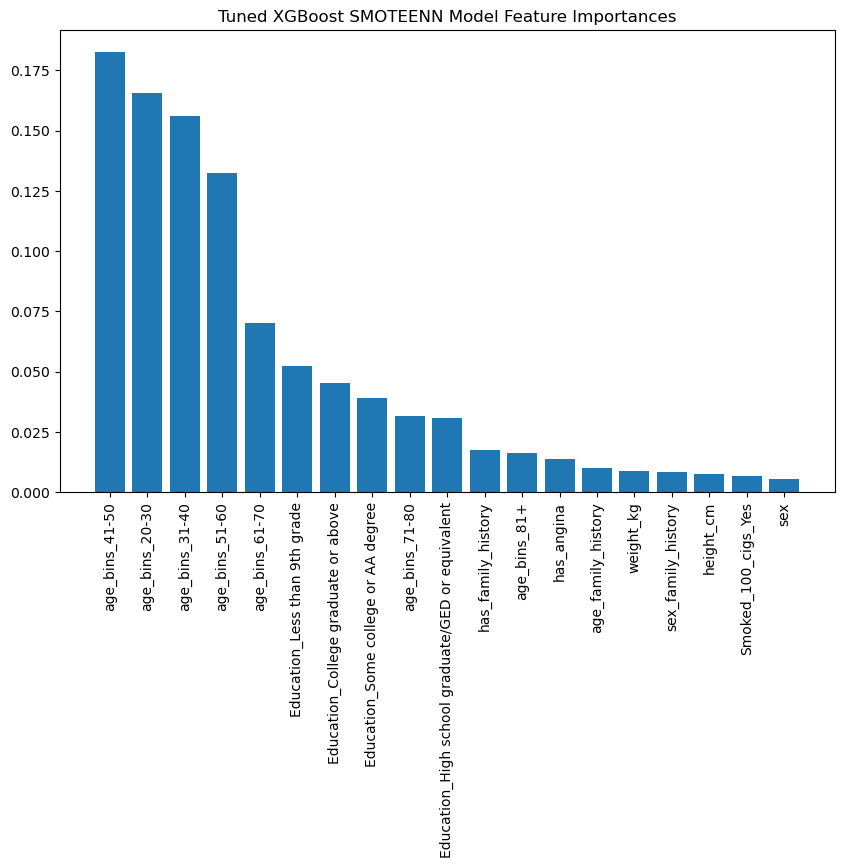

In [153]:
# Assuming xgb_model is your XGBoost model
importances_xgb_smoteenn = xgb_model_smoteenn_tuned.feature_importances_
indices_xgb = np.argsort(importances_xgb_smoteenn)[::-1]

# Plot feature importances
plt.figure(figsize=(10,6))
plt.title("Tuned XGBoost SMOTEENN Model Feature Importances")
plt.bar(range(len(importances_xgb_smoteenn)), importances_xgb_smoteenn[indices_xgb], align='center')
plt.xticks(range(len(importances_xgb_smoteenn)), X_train.columns[indices_xgb], rotation=90)
plt.show()

### Shap for XGB SMOTEENN Model

In [156]:
#computing shap values

#create shap explainer for RF model
explainer = shap.TreeExplainer(xgb_model_smoteenn_tuned)

#calculate SHAP values for test set
shap_values = explainer.shap_values(X_test)

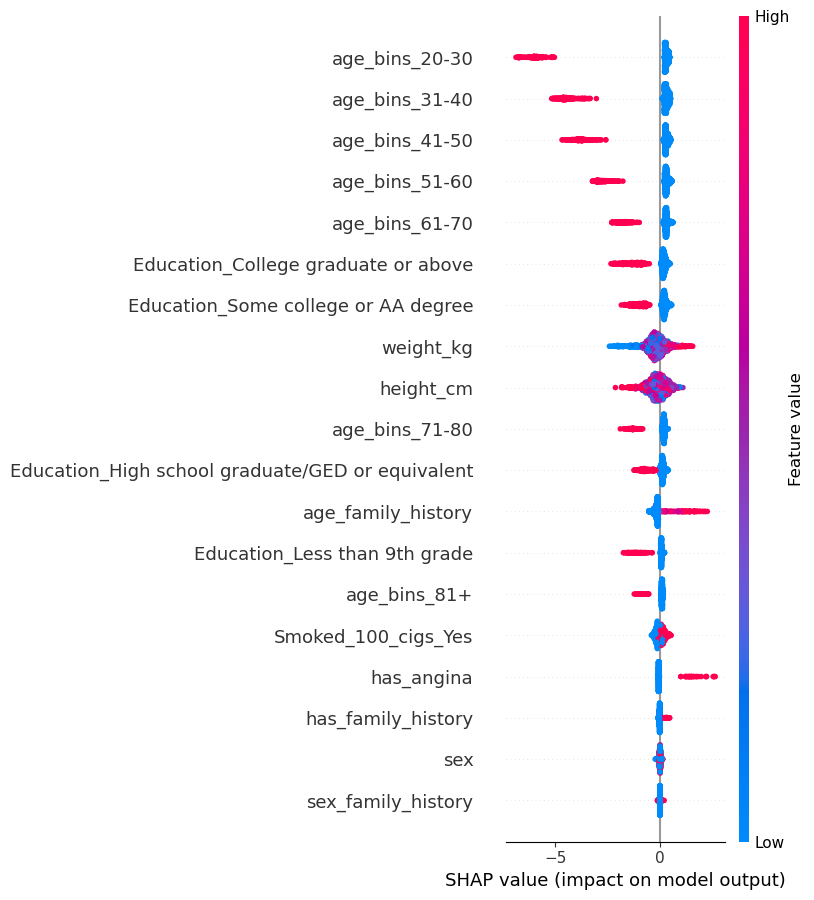

In [158]:
# shap summary plot
shap.summary_plot(shap_values[:,:], X_test)

In [169]:
Explainer = shap.Explainer(xgb_model_smoteenn_tuned, X_test)
shap_values = explainer(X_test)

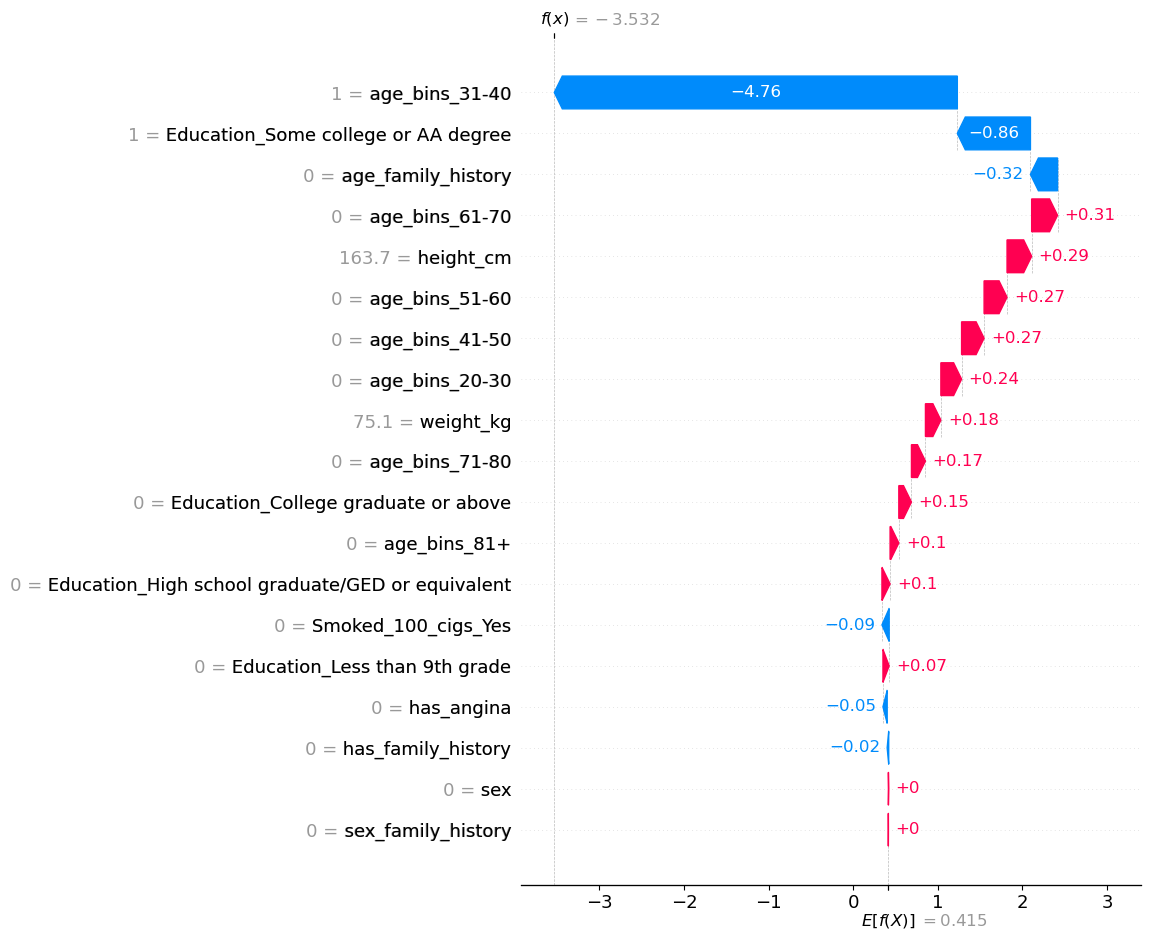

In [171]:
shap.plots.waterfall(shap_values[0], max_display=19)

In [172]:
y_prob_xgb_smoteenn_tuned  # Probabilities for the positive class


array([0.02841622, 0.02826514, 0.00546445, ..., 0.09937168, 0.7051072 ,
       0.14069945], dtype=float32)

In [175]:
# Define thresholds for high and low risk
high_risk_threshold = 0.9  # E.g., 90% probability for high risk
low_risk_threshold = 0.1   # E.g., 10% probability for low risk

# Identify indices of extreme cases
high_risk_indices = np.where(y_prob_xgb_smoteenn_tuned > high_risk_threshold)[0]
low_risk_indices = np.where(y_prob_xgb_smoteenn_tuned < low_risk_threshold)[0]

In [177]:
# Calculate SHAP values
explainer = shap.TreeExplainer(xgb_model_smoteenn_tuned)
shap_values = explainer.shap_values(X_test)

# Get SHAP values for extreme cases
shap_values_high_risk = shap_values[high_risk_indices]
shap_values_low_risk = shap_values[low_risk_indices]


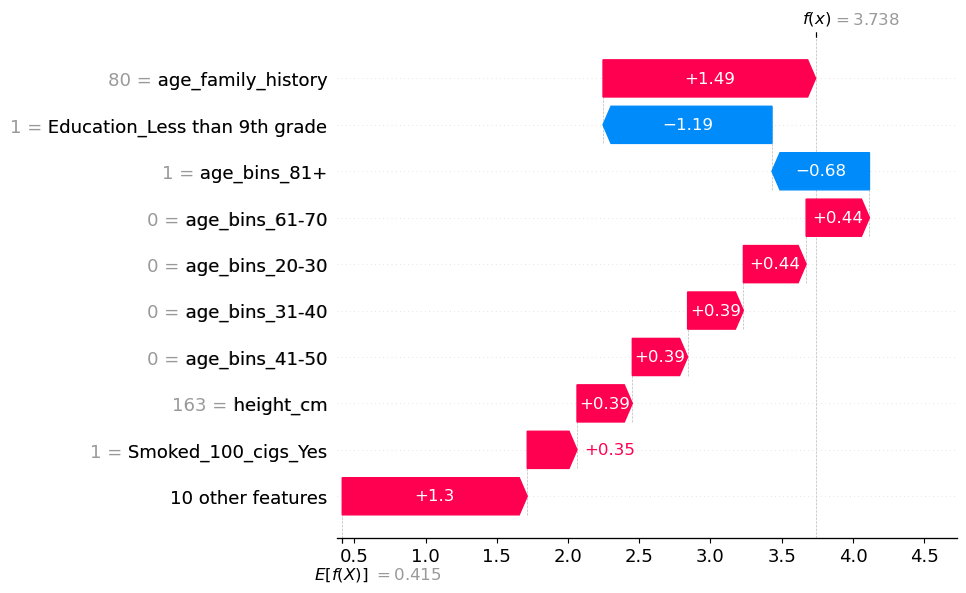

In [179]:
# Generate waterfall plots for high-risk cases
for i in high_risk_indices[:5]:  # Limit to first 5 for visualization purposes
     explanation = shap.Explanation(values=shap_values[i],
                                    base_values=explainer.expected_value,
                                    data=X_test.iloc[i],
                                    feature_names=X_test.columns)
shap.waterfall_plot(explanation)



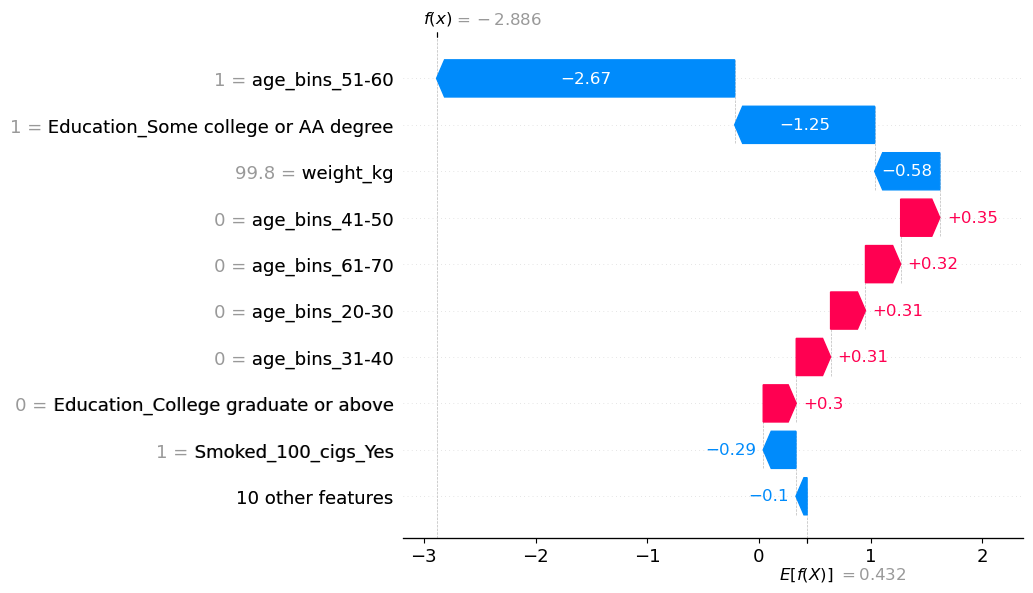

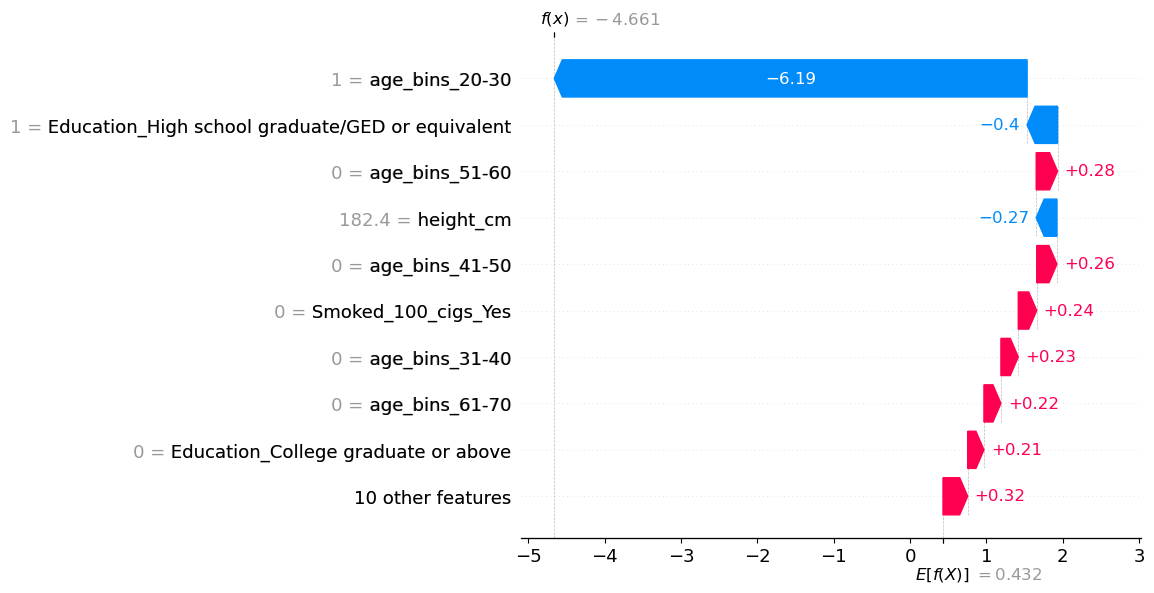

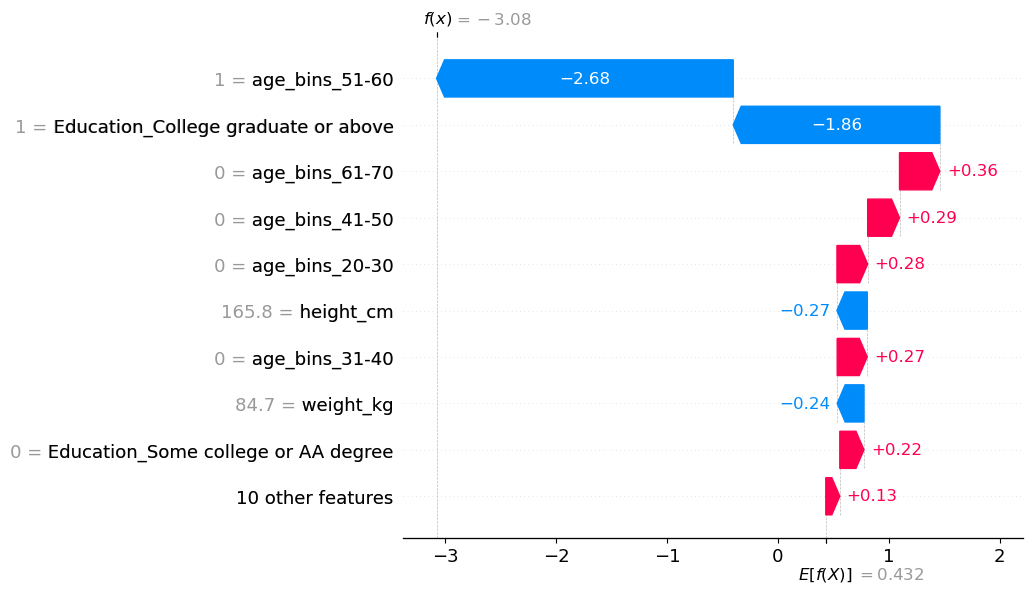

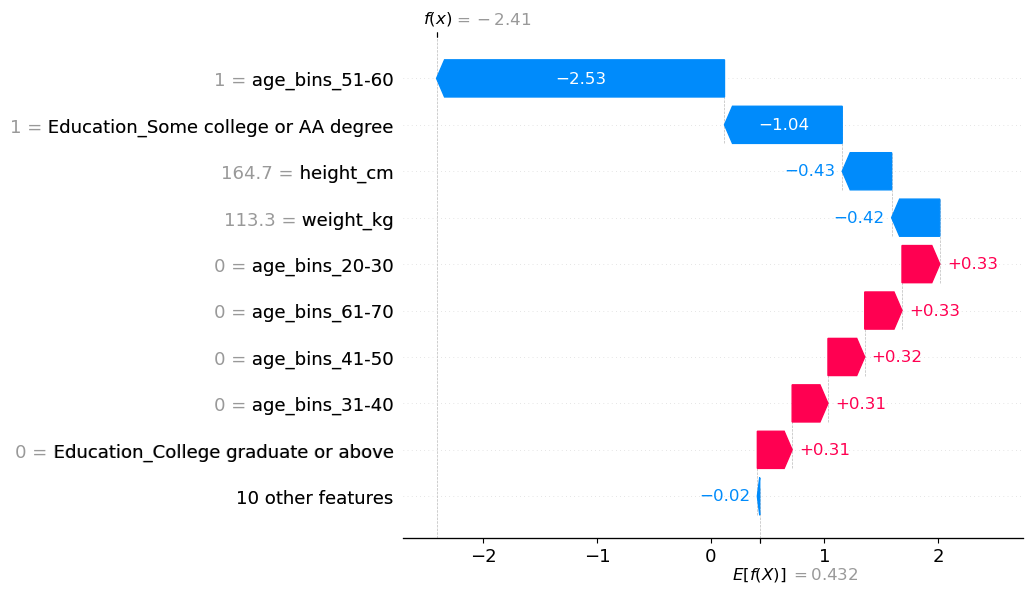

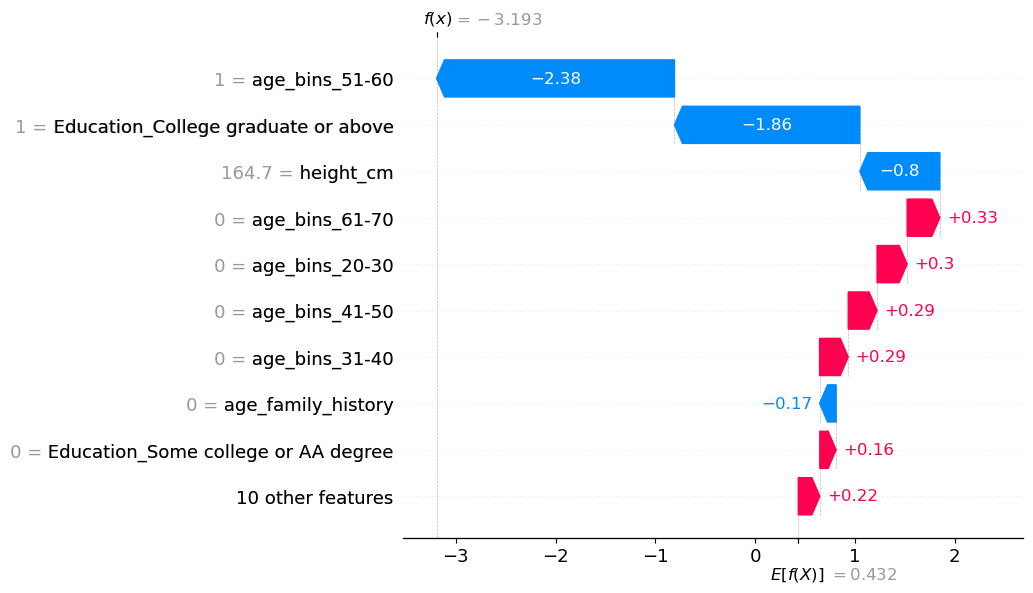

In [203]:
# Generate waterfall plots for low-risk cases
for i in low_risk_indices[:5]:  # Limit to first 5 for visualization purposes
    explanation = shap.Explanation(values=shap_values[i],
                                    base_values=explainer.expected_value,
                                    data=X_test.iloc[i],
                                    feature_names=X_test.columns)
    shap.waterfall_plot(explanation)


## Using ADASYN on XGB Model

In [181]:
from imblearn.over_sampling import ADASYN

In [186]:
# Perform ADASYN oversampling
adasyn = ADASYN(random_state=42)
X_train_resampled_adasyn, y_train_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

# Train XGBoost with resampled data
xgb_adasyn = xgb.XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)
xgb_adasyn.fit(X_train_resampled_adasyn, y_train_resampled_adasyn)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Evaluating without Threshold

In [189]:
# Evaluate
y_pred_adasyn = xgb_adasyn.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adasyn))
print("ADASYN - Classification Report:\n", classification_report(y_test, y_pred_adasyn))

Confusion Matrix:
 [[849 153]
 [ 55  53]]
ADASYN - Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89      1002
           1       0.26      0.49      0.34       108

    accuracy                           0.81      1110
   macro avg       0.60      0.67      0.61      1110
weighted avg       0.87      0.81      0.84      1110



### Evaluating with Threshold

In [192]:
# Predict probabilities
y_prob_xgb_adasyn= xgb_adasyn.predict_proba(X_test)[:, 1]

# Adjust the threshold
y_pred_custom_threshold_xgb_adasyn = (y_prob_xgb_adasyn >= 0.5).astype(int) #using default threshold

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold_xgb_adasyn))

# Evaluate with new threshold
print("\nClassification Report (Threshold 0.5):\n", classification_report(y_test, y_pred_custom_threshold_xgb_adasyn))

Confusion Matrix:
 [[849 153]
 [ 55  53]]

Classification Report (Threshold 0.5):
               precision    recall  f1-score   support

           0       0.94      0.85      0.89      1002
           1       0.26      0.49      0.34       108

    accuracy                           0.81      1110
   macro avg       0.60      0.67      0.61      1110
weighted avg       0.87      0.81      0.84      1110



### Using ADAYSYN on Tuned Hyperparameters XGB Model

In [195]:
from imblearn.pipeline import Pipeline

# Create ADASYN object
adasyn = ADASYN()

# Define the pipeline that applies ADASYN and then XGBoost
pipeline = Pipeline([
    ('adasyn', adasyn),  # Apply ADASYN resampling
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))  # XGBoost model
])

# Define the hyperparameter grid
param_grid = {
    'xgb__max_depth': [3, 5, 7],  # Note the 'xgb__' prefix for grid search
    'xgb__learning_rate': [0.1, 0.01, 0.001],
    'xgb__subsample': [0.5, 0.7, 1],
    'xgb__gamma': [0, 1, 10]
}

# Create GridSearchCV object
grid_search_xgb = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fitting GridSearchCV on the original (unresampled) training data
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters
print("Best parameters: ", grid_search_xgb.best_params_)

# Get the best model
best_xgb_model = grid_search_xgb.best_estimator_

# Evaluate the best model on the test set
test_accuracy = best_xgb_model.score(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

Best parameters:  {'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__subsample': 0.7}
Test Accuracy: 0.8829


In [197]:
# using best hyperparameters, setting max_delta_step to 1 for imbalanced dataset, and using SMOTE
xgb_model_adasyn_tuned = XGBClassifier(
    random_state=42,
     #scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    use_label_encoder=False,  # Disable warning for label encoding
    eval_metric='logloss',  # Set evaluation metric
    gamma=0,learning_rate=0.1, max_depth=7,subsample=0.7,max_delta_step=1) #best hyperparameters

xgb_model_adasyn_tuned.fit(X_train_resampled_adasyn, y_train_resampled_adasyn)

 # Handle class imbalance # scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [199]:
y_train_pred = xgb_model_adasyn_tuned.predict(X_train)
y_test_pred = xgb_model_adasyn_tuned.predict(X_test)

In [201]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9279
Test Accuracy: 0.8766


### Tuning Threshold with Tuned XGB ADASYN Model

In [203]:
# Predict on the test set 
y_prob_xgb_adasyn_tuned = xgb_model_adasyn_tuned.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
y_pred_custom_threshold_xgb_adasyn_tuned = (y_prob_xgb_adasyn_tuned >= 0.4).astype(int)  # Default threshold is 0.5, adjust if needed

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom_threshold_xgb_adasyn_tuned))
print("\nClassification Report with Threshold (0.4):\n", classification_report(y_test, y_pred_custom_threshold_xgb_adasyn_tuned))
print("\nAccuracy Score:\n", accuracy_score(y_test, y_pred_custom_threshold_xgb_adasyn_tuned))

Confusion Matrix:
 [[906  96]
 [ 62  46]]

Classification Report with Threshold (0.4):
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      1002
           1       0.32      0.43      0.37       108

    accuracy                           0.86      1110
   macro avg       0.63      0.67      0.64      1110
weighted avg       0.88      0.86      0.87      1110


Accuracy Score:
 0.8576576576576577


In [205]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_xgb_adasyn_tuned)

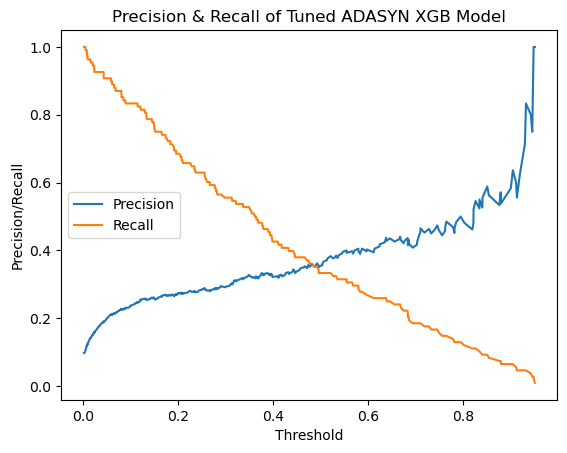

In [207]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision & Recall of Tuned ADASYN XGB Model')
plt.show()

#### Feature Importances

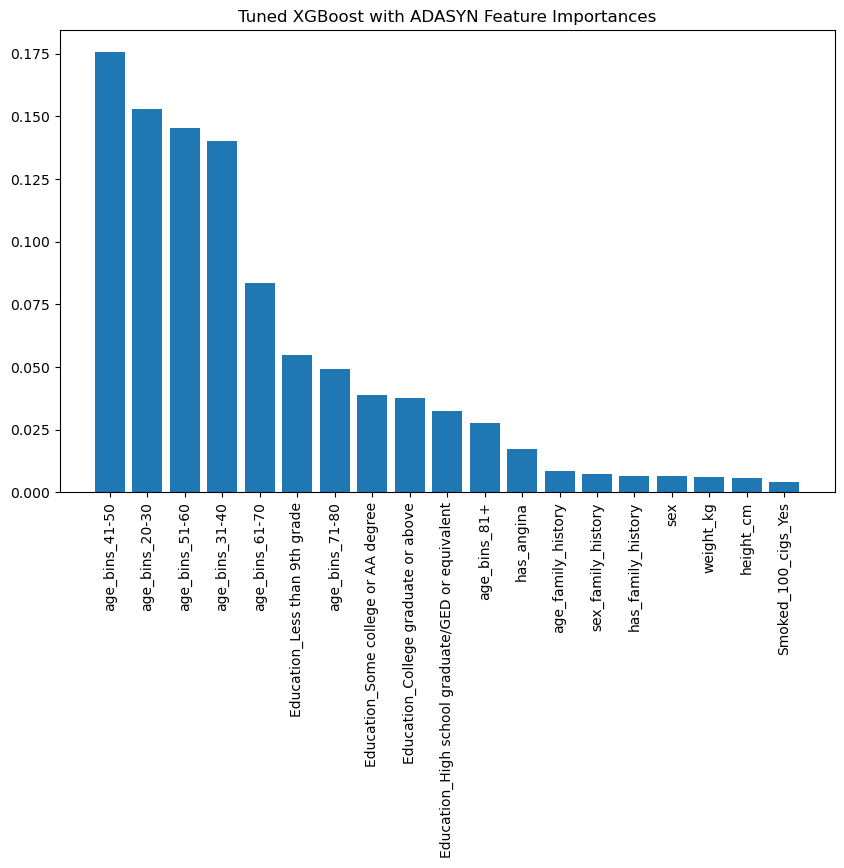

In [210]:
# Assuming xgb_model is your XGBoost model
importances_xgb_adasyn = xgb_model_adasyn_tuned.feature_importances_
indices_xgb = np.argsort(importances_xgb_adasyn)[::-1]

# Plot feature importances
plt.figure(figsize=(10,6))
plt.title("Tuned XGBoost with ADASYN Feature Importances")
plt.bar(range(len(importances_xgb_adasyn)), importances_xgb_adasyn[indices_xgb], align='center')
plt.xticks(range(len(importances_xgb_adasyn)), X_train.columns[indices_xgb], rotation=90)
plt.show()

In [212]:
#computing shap values

#create shap explainer for RF model
explainer = shap.TreeExplainer(xgb_model_adasyn_tuned, X_test)

#calculate SHAP values for test set
shap_values = explainer.shap_values(X_test)

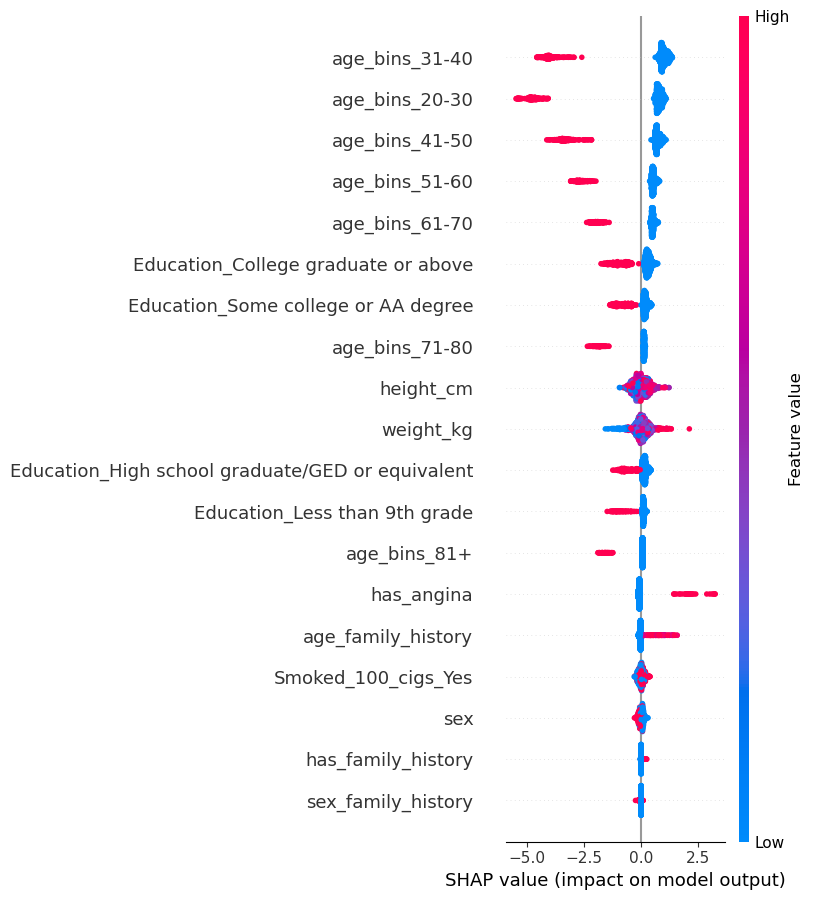

In [213]:
# shap summary plot
shap.summary_plot(shap_values[:,:], X_test)

## Blending RF, XGB with SMOTEENN and XGB with ADASYN Models

### Simple Averaging of Predictions Approach 

In [216]:
# getting predictions from each model 
# Step 1: Get predicted probabilities from both models on the test set
y_prob_rf_smoteenn_tuned = rf_smoteenn_tuned.predict_proba(X_test)[:, 1]  # Probabilities for Random Forest
y_prob_xgb_smoteenn_tuned = xgb_model_smoteenn_tuned.predict_proba(X_test)[:, 1]  # Probabilities for XGBoost (SMOTEENN)
y_prob_xgb_adasyn_tuned = xgb_model_adasyn_tuned.predict_proba(X_test)[:, 1]  # Probabilities for XGBoost (ADASYN)

In [218]:
# Step 2: Average the probabilities (soft voting)
y_prob_blended = (y_prob_rf_smoteenn_tuned + y_prob_xgb_smoteenn_tuned + y_prob_xgb_adasyn_tuned) / 3

In [220]:
# Step 3: Convert probabilities to binary predictions using a threshold (0.5 by default, can be adjusted)
threshold = 0.5
y_pred_blended = (y_prob_blended >= threshold).astype(int)

In [222]:
# Step 4: Evaluate the blended model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_blended))
print("\nClassification Report with Threshold (0.5):\n", classification_report(y_test, y_pred_blended))
print("\nAccuracy Score:\n", accuracy_score(y_test, y_pred_blended))

Confusion Matrix:
 [[877 125]
 [ 52  56]]

Classification Report with Threshold (0.5):
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      1002
           1       0.31      0.52      0.39       108

    accuracy                           0.84      1110
   macro avg       0.63      0.70      0.65      1110
weighted avg       0.88      0.84      0.86      1110


Accuracy Score:
 0.8405405405405405


In [224]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_blended)

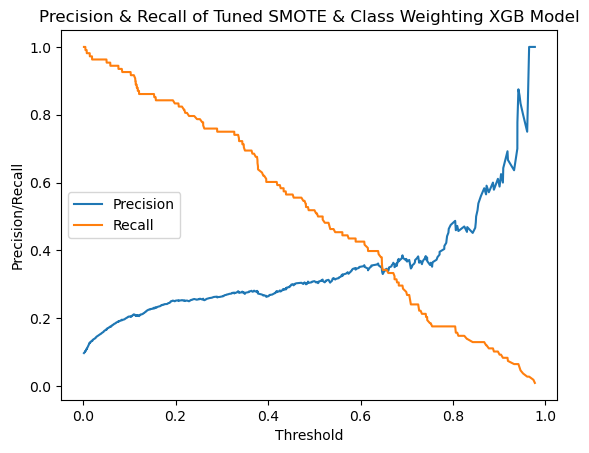

In [226]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision & Recall of Tuned SMOTE & Class Weighting XGB Model')
plt.show()

### Threshold Tuning 

In [229]:
threshold = 0.35
y_pred_blended = (y_prob_blended >= threshold).astype(int)

In [231]:
# Step 4: Evaluate the blended model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_blended))
print("\nClassification Report with Threshold (0.35):\n", classification_report(y_test, y_pred_blended))
print("\nAccuracy Score:\n", accuracy_score(y_test, y_pred_blended))

Confusion Matrix:
 [[804 198]
 [ 33  75]]

Classification Report with Threshold (0.35):
               precision    recall  f1-score   support

           0       0.96      0.80      0.87      1002
           1       0.27      0.69      0.39       108

    accuracy                           0.79      1110
   macro avg       0.62      0.75      0.63      1110
weighted avg       0.89      0.79      0.83      1110


Accuracy Score:
 0.7918918918918919


#### Feature Importances

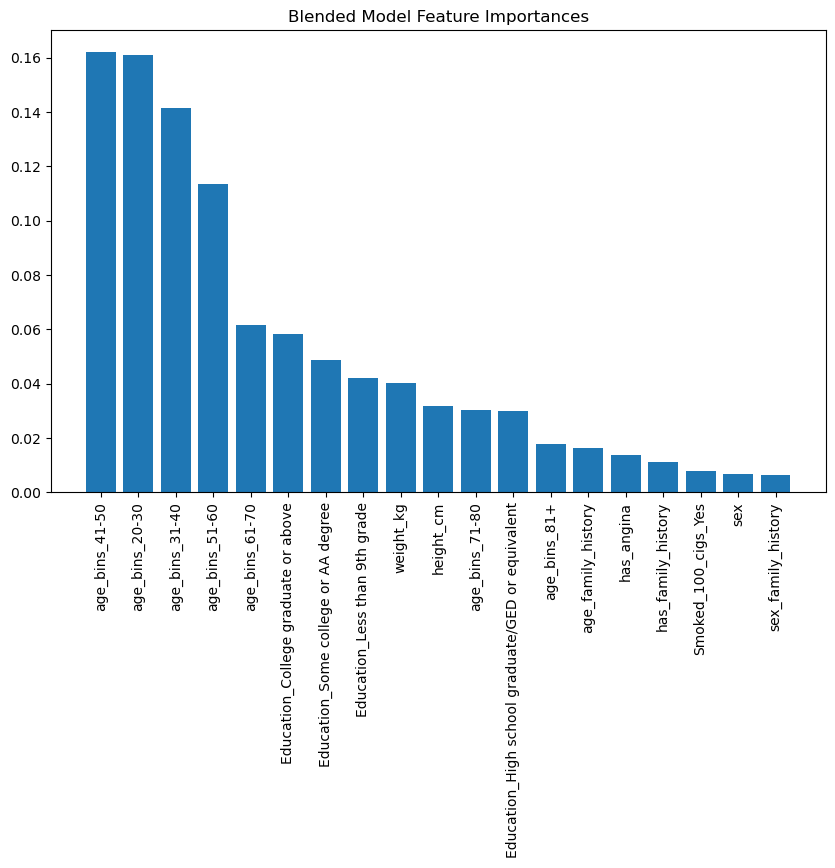

In [234]:
# Average feature importances from multiple models
combined_importances = (importances_rf + importances_xgb_smoteenn + importances_xgb_adasyn) / 3
indices_combined = np.argsort(combined_importances)[::-1]

# Plot combined feature importances
plt.figure(figsize=(10,6))
plt.title("Blended Model Feature Importances")
plt.bar(range(len(combined_importances)), combined_importances[indices_combined], align='center')
plt.xticks(range(len(combined_importances)), X_train.columns[indices_combined], rotation=90)
plt.show()

## Boosting on Top of Blended Predictions (Meta Learner)

### Creating Blended Probability as New Feature

In [219]:
# Step 1: Get predicted probabilities from the training set for each model
y_prob_rf_smoteenn_tuned_train = rf_smoteenn_tuned.predict_proba(X_train)[:, 1]  # Random Forest
y_prob_xgb_smoteenn_tuned_train = xgb_model_smoteenn_tuned.predict_proba(X_train)[:, 1]  # XGBoost (SMOTEENN)
y_prob_xgb_adasyn_tuned_train = xgb_model_adasyn_tuned.predict_proba(X_train)[:, 1]  # XGBoost (ADASYN)

In [227]:
# Step 2: Average the probabilities for the training set (soft voting)
y_prob_blended_train = (y_prob_rf_smoteenn_tuned_train + y_prob_xgb_smoteenn_tuned_train + y_prob_xgb_adasyn_tuned_train) / 3

In [229]:
# Assuming you have blended probabilities from each model
X_train_blended = np.array(y_prob_blended_train).reshape(-1,1) # reshape for training

### Training Meta Learner Model with Tuned RF and XGB SMOTEENN, and XGB ADASYN Blended Models

In [424]:
# Initialize the meta-learner (boosting model)
meta_learner = XGBClassifier()

# Fit the meta-learner using the blended probabilities (X_train_blended)
meta_learner.fit(X_train_blended,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [426]:
# Step 4: Get predicted probabilities from the test set for the meta-learner
y_prob_rf_smoteenn_tuned_test = rf_smoteenn_tuned.predict_proba(X_test)[:, 1]
y_prob_xgb_smoteenn_tuned_test = xgb_model_smoteenn_tuned.predict_proba(X_test)[:, 1]
y_prob_xgb_adasyn_tuned_test = xgb_model_adasyn_tuned.predict_proba(X_test)[:, 1]


In [428]:
# Average the probabilities for the test set (soft voting)
y_prob_blended_test = (y_prob_rf_smoteenn_tuned_test + y_prob_xgb_smoteenn_tuned_test + y_prob_xgb_adasyn_tuned_test) / 3

In [430]:
# Step 5: Get predictions from the meta-learner for the test set
meta_test_probs = meta_learner.predict_proba(y_prob_blended_test.reshape(-1, 1))[:, 1]

In [432]:
# Apply a threshold to get the final predictions
threshold = 0.5  # or adjust as needed
meta_y_pred = (meta_test_probs >= threshold).astype(int)


In [434]:
# Evaluate the boosted blended model
print("Confusion Matrix:\n", confusion_matrix(y_test, meta_y_pred))
print("\nClassification Report:\n", classification_report(y_test, meta_y_pred))
print("\nAccuracy Score:\n", accuracy_score(y_test, meta_y_pred))

Confusion Matrix:
 [[955  47]
 [ 80  28]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      1002
           1       0.37      0.26      0.31       108

    accuracy                           0.89      1110
   macro avg       0.65      0.61      0.62      1110
weighted avg       0.87      0.89      0.88      1110


Accuracy Score:
 0.8855855855855855


### Tuning Threshold on Base Boosting Model

In [437]:
# Apply a threshold to get the final predictions
threshold = 0.03 # or adjust as needed
meta_y_pred = (meta_test_probs >= threshold).astype(int)

In [439]:
precision, recall, thresholds = precision_recall_curve(y_test, meta_test_probs)

In [441]:
# Evaluate the boosted blended model
print("Confusion Matrix:\n", confusion_matrix(y_test, meta_y_pred))
print("\nClassification Report:\n", classification_report(y_test, meta_y_pred))
print("\nAccuracy Score:\n", accuracy_score(y_test, meta_y_pred))

Confusion Matrix:
 [[822 180]
 [ 44  64]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.82      0.88      1002
           1       0.26      0.59      0.36       108

    accuracy                           0.80      1110
   macro avg       0.61      0.71      0.62      1110
weighted avg       0.88      0.80      0.83      1110


Accuracy Score:
 0.7981981981981981


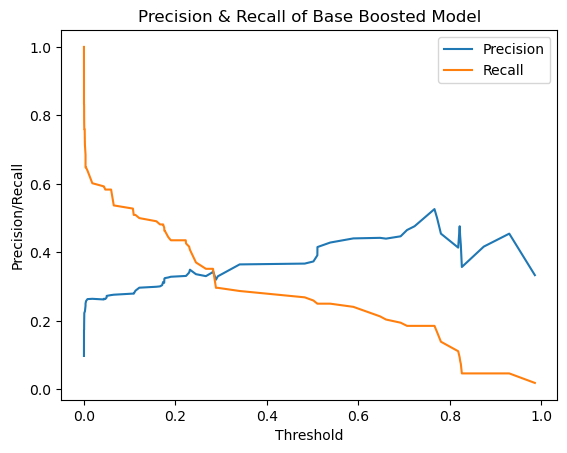

In [302]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision & Recall of Base Boosted Model')
plt.show()

### Hyperparameter Tuning on Boosting Model

In [443]:
X_train_blended = np.array(y_prob_blended_train).reshape(-1, 1)  # Blended probabilities for the training set


In [447]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

In [449]:
# Grid search
grid_search_meta = GridSearchCV(estimator=meta_learner, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_meta.fit(X_train_blended, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200]},
             verbose=2)

In [453]:
# Use the best model for predictions
best_meta_learner = grid_search_meta.best_estimator_

# Print the best parameters
print("Best parameters: ", grid_search_meta.best_params_)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [457]:
# Reshape blended test probabilities
X_test_blended = np.array(y_prob_blended_test).reshape(-1, 1)

# Use the best meta-learner to predict probabilities on the test set
best_meta_test_probs = best_meta_learner.predict_proba(X_test_blended)[:, 1]


In [489]:
# Convert probabilities to binary predictions using a threshold (you can adjust the threshold)
threshold = 0.01
best_meta_y_pred = (best_meta_test_probs >= threshold).astype(int)

In [491]:
# Evaluate the tuned meta-learner model
print("Confusion Matrix:\n", confusion_matrix(y_test, best_meta_y_pred))
print("\nClassification Report:\n", classification_report(y_test, best_meta_y_pred))
print("\nAccuracy Score:\n", accuracy_score(y_test, best_meta_y_pred))

Confusion Matrix:
 [[777 225]
 [ 34  74]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.78      0.86      1002
           1       0.25      0.69      0.36       108

    accuracy                           0.77      1110
   macro avg       0.60      0.73      0.61      1110
weighted avg       0.89      0.77      0.81      1110


Accuracy Score:
 0.7666666666666667


In [469]:
precision, recall, thresholds = precision_recall_curve(y_test, best_meta_test_probs)

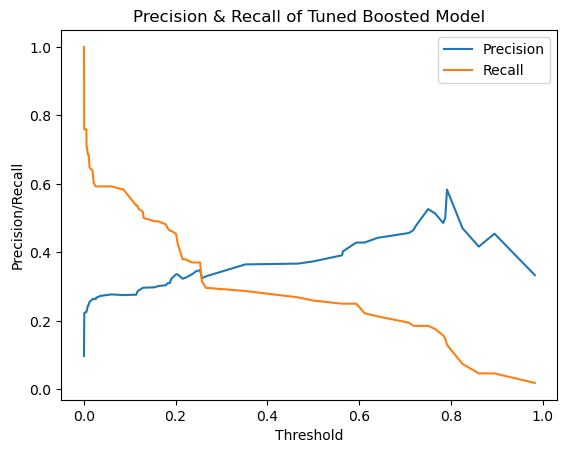

In [471]:
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision & Recall of Tuned Boosted Model')
plt.show()

## Deploying Best Model (Blended RF SMOTEENN, XGB SMOTEENN, XGB ADASYN)

In [238]:
import joblib

In [240]:
# Save each individual model
joblib.dump(rf_smoteenn_tuned, 'rf_smoteenn_tuned.pkl')
joblib.dump(xgb_model_smoteenn_tuned, 'xgb_model_smoteenn_tuned.pkl')
joblib.dump(xgb_model_adasyn_tuned, 'xgb_model_adasyn_tuned.pkl')

['xgb_model_adasyn_tuned.pkl']

In [242]:
# Save blending logic as a function or class
def blended_model_predict(X):
    y_prob_rf = rf_smoteenn_tuned.predict_proba(X)[:, 1]
    y_prob_xgb_smoteenn = xgb_model_smoteenn_tuned.predict_proba(X)[:, 1]
    y_prob_xgb_adasyn = xgb_model_adasyn_tuned.predict_proba(X)[:, 1]
    
    # Average probabilities
    y_prob_blended = (y_prob_rf + y_prob_xgb_smoteenn + y_prob_xgb_adasyn) / 3
    return y_prob_blended

In [244]:
joblib.dump(blended_model_predict, 'blended_model_predict.pkl')

['blended_model_predict.pkl']